
<h1 style="text-align: center;"> <b> Homework II </b> </h1>
  
    
<h2 style="text-align: center;">Markov Chains</h2>
<h3 style="text-align: center;">Networks dynamics and learning - Politecnico di Torino</h3>
<h3 style="text-align: center;"> Erich Malan s267475</h3>
<p style="text-align: center;">The homework has been carried out alone but then it has been checked and discussed with course students: Davide Bussone, Pedro Ramirez Hernandez, Alessandro Nicolì</p>

In [40]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse, text-align: center;}</style>'))

In [1]:
import networkx as nx
import numpy as np
from numpy.random import choice, rand 
import numpy as np
np.random.seed(42)


# Excercise 1

### Definition of $\Lambda$ and graph

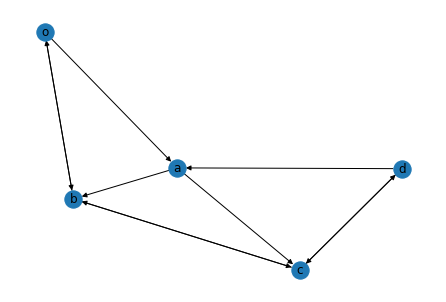

In [39]:
lam = np.array([[0,2/5,1/5,0,0],
                [0,0,3/4,1/4,0],
                [1/2,0,0,1/2,0],
                [0,0,1/3,0,2/3],
                [0,1/3,0,1/3,0]])
edges = []
nodes = [x for x in "oabcd"]
for r,row in enumerate(lam):
    for c,col in enumerate(row):
        edges.append((nodes[r],nodes[c],col))
        
        
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)
to_remove = []
for n, nbrs in G.adj.items():
    for nbr, eattr in nbrs.items():
        wt = eattr['weight']
        if not wt > 0.0: 
            to_remove.append((n,nbr,wt))
G.remove_edges_from(to_remove)

pos = nx.layout.spring_layout(G)

nx.draw(G,pos,with_labels=True)
node_map_inv = dict(enumerate(G.nodes))
node_map = {v: k for k, v in node_map_inv.items()}

In [3]:
w = np.sum(lam,axis=1)
print("Degrees ",w)
print()
D = np.diag(w)
P = np.linalg.inv(D) @ lam
print('P matrix')
print(P)
print()
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)
print('pi')
print(pi)

Degrees  [0.6        1.         1.         1.         0.66666667]

P matrix
[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.5        0.         0.5        0.        ]]

pi
[0.13043478 0.17391304 0.26086957 0.26086957 0.17391304]


### Continuous time case, matrix definitions

In [4]:
w_star = np.max(w)
P_bar = lam/w_star 
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))
print('P_bar')
print(P_bar)
values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print()
print("pi_bar = ", pi_bar)

P_bar
[[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.33333333]]

pi_bar =  [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


Notice that $\bar{\pi} \neq \pi$ but they are related, another analytic way to find $\bar{\pi}$ could be:

$$
\bar{\pi}_i = \frac{\frac{\pi_i}{w_i}}{\sum_j{\frac{\pi_j}{w_j}}}
$$

In [5]:
piw = pi/w
piwi = sum(piw)
pibs = piw / piwi
print('pi_bar: ',pibs)

pi_bar:  [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


## 1.a) Simulations of the expected return time

The random walk simulated in this case stops when a node return to the departing node. It is computed by considering the discrete Jumping Chain $U(N_t)$ associated with transition probabilities $\frac{\Lambda_{i,j}}{w_i} \quad \forall$ jump from i to j which happens after $\hat{\tau}$, a random variable distributed accordingly the exponential distribution of rate-r. Pratically considering $u \sim U(0,1)$ uniform random variable 
$$
\hat{\tau} = \frac{-ln(u)}{r}
$$ 
Each node has his proper rate r = $w_i$

In [6]:
# Simulates a random walk on the graph G, starting from node xi.
# the random walk stops the first time it returns to the starting node xi.

def RandomWalk(G, xi, Pdist, nm, w):
    # nodeSeq stores the sequence of visited nodes
    nodeSeq = []
    nodeSeq.append(xi)

    # stores the initial position to check if the 
    # walk returns to it
    x_init = xi
    t_next = -np.log(np.random.rand())/w[nm[xi]]
    transition_times = [0]
    i = 0
    while True:
        i += 1
        if Pdist is not None:
            pd = Pdist[nm[xi],:]
        # compute the next visited node xi by chosing accordingly to the transition probability matrix 
        # at random a neighbor of the current one
        xi = str(choice(G.nodes,1, p=pd)[0]) 
        nodeSeq.append(xi)
        
        # compute the waiting time to the next transition
        t_next = -np.log(np.random.rand())/w[nm[nodeSeq[-2]]]
        transition_times.append(transition_times[i-1] + t_next)
        # check if the walk has returned to the starting node
        # if so, end the walk
        if xi == x_init and i>1:
            return nodeSeq, transition_times


In [7]:
ts = []
for steps in range(10000):
    walk,times = RandomWalk(G, 'a', Pdist=P, nm=node_map, w = w)
    ts.append(times[-1])
print('average simulation time: ',np.mean(ts))

average simulation time:  6.800346288012771


## 1.b) Analytical ways to calculate the expected return time on node A

Here there are 2 different possibilities to calculate the expected return time on 'a'. The simpler one is considering that the graph is strongly connencted then it could be applied the transposition in continuous time of the Kac's formula.
Kac's formula:
$$
 \mathop{\mathbb{E_i}}[T_i^+] = \frac{1} {\pi_i}
$$

which becomes:
$$
 \mathop{\mathbb{E_i}}[T_i^+] = \frac{1} {w_i\bar{\pi_i}}
$$

Otherwise it could be calculated by considering the hitting times on node i and then obtain  $\mathop{\mathbb{E_i}}[T_i^+]$ by solving the
General formula:
$$
 \mathop{\mathbb{E_i}}[T_i^+] = \frac{1}{w_i} + \sum_j{P_{i,j}\mathop{\mathbb{E_j}}[T_i]}
$$


#### a) by considering that the graph is strongly connected we can take advantage of the Kac's law transposed into the continuous time

In [8]:
tau_a_kac = 1 / (w[1]*pi_bar[1])
print('Expected return time: ',tau_a_kac)

Expected return time:  6.750000000000007


#### b) The expected hitting time is found by solving the linear system 

In [9]:
n_nodes = G.number_of_nodes()

# Define the set S and the remaining nodes R
S = [1]
# same as R=np.setdiff1d(np.array(range(n)),S)
R = [node for node in range(n_nodes) if node not in S]

# Restrict P to R x R to obtain hat(P)
hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]
# solve the linear system to obtain hat(x)
# np.linalg.solve solves a linear matrix equation given
# the coefficient matrix and the dependent variable values
hatx = np.linalg.solve((np.identity(n_nodes-len(S))-hatP),(np.ones(n_nodes-len(S))/hatw))

# define the hitting times to the set S
# hitting time is 0 if the starting node is in S
hitting_s = np.zeros(n_nodes)
# hitting time is hat(x) for nodes in R
hitting_s[R] = hatx

print('expected hitting times on a: ',hitting_s)

expected hitting times on a:  [3.57142857 0.         5.71428571 5.85714286 4.42857143]


While to obtain the expected return time:

In [10]:
tau_a = 1/w[1] + P[1,:] @ hitting_s
print('Expected return time: ',tau_a)

Expected return time:  6.75


## 1.c) Expected hitting time from $o$ to $d$ (simulation)

Again we use the sam random walk but this time the arrival node is not the same as the departure

In [11]:
def RandomWalkPath(G, x_init, yi, Pdist = None, nm = None, w = None):
    nodeSeq = []
    nodeSeq.append(x_init)
    xi = x_init
    t_next = -np.log(np.random.rand())/w[nm[x_init]]
    transition_times = [0]
    i = 0
    while True:
        i += 1
        if Pdist is not None:
            pd = Pdist[nm[xi],:]
        # compute the next visited node xi by chosing accordingly to the transition probability matrix 
        # at random a neighbor of the current one
        xi = str(choice(G.nodes,1, p=pd)[0]) 
        nodeSeq.append(xi)
        # compute the waiting time to the next transition
        
        t_next = -np.log(np.random.rand())/w[nm[nodeSeq[-2]]]
        transition_times.append(transition_times[-1] + t_next)
        # check if the walk got to the arrival node
        # if so, end the walk
        if xi == yi and i > 1:
            return nodeSeq, transition_times

In [12]:
ts = []
for steps in range(10000):
    walk,times = RandomWalkPath(G,'o','d',P, nm=node_map, w = w)
    ts.append(times[-1])
print('Avg simulation hitting time (o->d): ',np.mean(ts))

Avg simulation hitting time (o->d):  8.722606846807755


#### 1.c.bis)

This simulation is almost the same but this times it considers the cumulative sum over $\bar{P}$ to check where the particle should move.

In [13]:
def RandomWalkPathBis(G, xi, yi, Q_cum, nm, ws = 1):
    nodeSeq = []
    nodeSeq.append(xi)
    t_next = -np.log(np.random.rand())/ws
    transition_times = [0]
    i = 0
    while True:
        i += 1
        xi = np.argwhere(Q_cum[xi] >= np.random.rand())[0][0]
        nodeSeq.append(xi)
        # compute the waiting time to the next transition
        
        t_next = -np.log(np.random.rand())/ws
        transition_times.append(transition_times[-1] + t_next)
        # check if the walk has returned to the ending node
        # if so, end the walk
        if xi == yi and i > 1:
            return nodeSeq, transition_times

Q_cum is the cumulative distribution matrix of $\bar{P}$

In [14]:
Q_cum = np.cumsum(P_bar, axis=1)

In [15]:
ts = []
for steps in range(10000):
    walk,times = RandomWalkPathBis(G,0,4,Q_cum, nm=node_map, ws = w_star)
    ts.append(times[-1])
print('Avg simulation hitting time (o->d): ',np.mean(ts))

Avg simulation hitting time (o->d):  8.794345722384687


## 1.d) Theoretical expected hitting time (o -> d)

The theoretical expected hitting time $\mathop{\mathbb{E_i}}[T_j]$ is found by solving $\mathop{\mathbb{E_i}}[T_j] = \frac{1}{wi} + \sum_{j \in X}{P_{i,j}}\mathop{\mathbb{E_j}}[T_i]$  $\forall i \in S $. Given $\hat{P}$ the matrix obtained by eliding the cols and rows corresponding S-nodes, the vector $\hat{b} = \mathbf{1} / \hat{w} $ the solution is found by solving the linear system:

$$
\hat{x} = (I - \hat{P})^{-1} \mathbf{\hat{b}}
$$

In [16]:
n_nodes = G.number_of_nodes()
S = [4]
R = [node for node in range(n_nodes) if node not in S]
hatP = P[np.ix_(R, R)]
hatw = w[np.ix_(R)]
hatx = np.linalg.solve((np.identity(n_nodes-len(S))-hatP),(np.ones(n_nodes-len(S))/hatw))
hitting_s = np.zeros(n_nodes)
hitting_s[R] = hatx
hitting_s[0]

8.785714285714285

# Excercise 2

Theoretically given the independent relation between particles the simulation could be done by repeating the point 1.a hundred of times, but to give another possible solution will be presented the results of the global clock solution. More specifically at each iteration a particle is randomly selected with propability $\mathop{P} = \frac{1}{100}$ (uniform distribution without extraction). The poisson process has rate-r = #particles in this case
$$
\hat{\tau} = \frac{-ln(u)}{100}
$$

There are 2 different possibilities, compute again $\bar{P}$ and relative Q_cum and choose how many particles should move to the next node, or leave it as it is and move one particle at a time (this one is subject of the simulation)

### a.1)

In [17]:
particles = range(100)
part_node = np.ones(len(particles)).astype(np.int) #node 1 for every particle, pos = particle id
num_ret = np.zeros(len(particles)).astype(np.int) #number of returns per particles
g_clock = len(particles)


def get_node_dist(x):
    cppn = np.column_stack(np.unique(x, return_counts=True))
    node_dist = np.zeros(len(G.nodes))
    node_dist[cppn[:,0]] = cppn[:,1]#/sum(cppn[:,1])
    return node_dist



# the random time to wait for the next transition
# is drawn according to its distribution
# NOTE: in the formula for t_next we use w_sys, the system Poisson clock with rate 100
# NOTE2: Q has not been computed again with the new clock, instead of considering how many particles 
# remain in node and how many leave it I preferred to move a single particle at a time

#extractions = []
n_iter = 10000
elapsed_time= 0
for i in range(n_iter):
    #if len(extractions) == len(particles):
    #    extractions = []  [par for par in particles if par not in extractions]
    p_to_move = choice(particles,1)[0] #choose randomly a particle with extraction
    #extractions.append(p_to_move)
    prev_pos = part_node[p_to_move] # defines the current position of the particle
      #check the conditional probabilities
                        # compute the next visited node xi by chosing accordingly to P distribution
                        # at random a neighbor of the current one
    xi = np.argwhere(Q_cum[prev_pos] >= np.random.rand())[0][0]
    # compute the next visited node xi by chosing accordingly to the transition probability matrix 
    # at random a neighbor of the current one
    part_node[p_to_move] = xi
    t_next = -np.log(np.random.rand())/g_clock
    elapsed_time += t_next
    if xi == 1:
        num_ret[p_to_move] += 1

#### Simulated return time

In [18]:
elapsed_time/np.mean(num_ret)

6.698386846450156

### a.2)

As expected, the expected return time $\mathop{\mathbb{E_i}}[T_i^+]$ does not change that much compared to the single particle random walk. It would be more similar with the same process but with extractions of the particles, but for infinite attempts they should converge to the same value.

## 2b)

By the node perspective each node has a rate $w_i * n_{p(i)}$ (proportional to the number of particles) and so
$$
\hat{\tau_i} = \frac{-ln(u)} {n_i w_i}
$$

In [19]:
node_part = np.zeros(len(G))
node_part[0] = 100
part_dist_time = np.array(node_part)
transition_times = [0]
elapsed_time = 0
P_cum = np.cumsum(P, axis=1)

while elapsed_time < 60:
    t_nexts = -np.log(np.random.rand(len(G)))/((node_part+1e-10)*w)#each node has a proper clock, 
                                                                # distributed accordingly to the random Poisson 
                                                                # process with rate-r w[i]*#particles[i]
    t_next = min(t_nexts)
    departure_node = np.argwhere(t_nexts == t_next)[0][0]
    arrival_node = np.argwhere(P_cum[departure_node] >= np.random.rand())[0][0] 
                                                                # the next node is choosen accordingly to 
                                                                # probabilities Lamda(i,j)/w(i)
    node_part[departure_node] -= 1
    node_part[arrival_node] += 1
    elapsed_time += t_next
    part_dist_time = np.column_stack((part_dist_time,node_part))
    transition_times.append(transition_times[-1] + t_next)

In [20]:
np.mean(part_dist_time,axis=1)

array([20.59634485, 15.88160509, 21.74711959, 20.82578466, 20.94914581])

#### b.2)
The average of particles over time converges to $100 \bar{\pi}$. Actually the avg of node 0 is a little bit higher because it starts with every particle inside, but for longer periods it should converge.

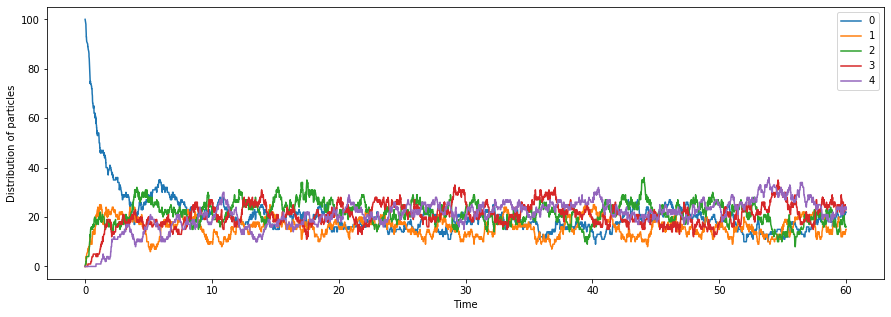

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node].T,label=node)
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()

# Excercise 3

In [22]:
Lambda = np.array([[0,2/3,1/3,0,0],
                [0,0,1/4,1/4,2/4],
                [0,0,0,1,0],
                [0,0,0,0,1],
                [0,0,0,0,0]])
w = np.sum(Lambda, axis=1)
w_star = np.max(w)
P_bar = Lambda/w_star 
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))
print('P_bar:\n',P_bar)
print()
values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar = ", pi_bar)

Q_cum = np.cumsum(P_bar, axis=1)
print()
print('Q_cum = \n',Q_cum)

P_bar:
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.25       0.25       0.5       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         1.        ]]

pi_bar =  [0. 0. 0. 0. 1.]

Q_cum = 
 [[0.         0.66666667 1.         1.         1.        ]
 [0.         0.         0.25       0.5        1.        ]
 [0.         0.         0.         1.         1.        ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         1.        ]]


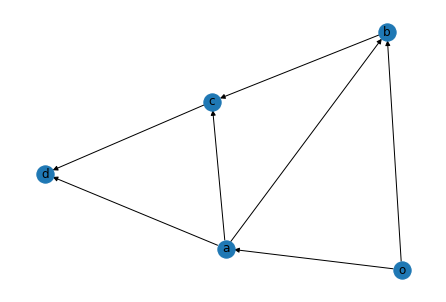

In [23]:
edges = []
nodes = [x for x in "oabcd"]
for r,row in enumerate(Lambda):
    for c,col in enumerate(row):
        edges.append((nodes[r],nodes[c],col))
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)
to_remove = []
for n, nbrs in G.adj.items():
    for nbr, eattr in nbrs.items():
        wt = eattr['weight']
        if not wt > 0.0: 
            to_remove.append((n,nbr,wt))
G.remove_edges_from(to_remove)

pos = nx.layout.spring_layout(G)

nx.draw(G,pos,with_labels=True)
node_map_inv = dict(enumerate(G.nodes))
node_map = {v: k for k, v in node_map_inv.items()}

### 3.a)

Simulation with an input rate = 1 and node rates proportional to the number of particles contained

In [24]:
input_rate = 1

In [25]:
num_particles = 0
n_enter = 0
part_dist_time = np.array(np.zeros(len(G.nodes)))
transition_times = [0]
elapsed_time = 0
next_input = 0
node_dist = np.zeros(len(G.nodes))

while elapsed_time < 60:
    if num_particles == 0: # this happens when the graph is empty, it must wait until a particle enters the system
        t_next = -np.log(np.random.rand())/input_rate #the only clock that tick is the input clock
        next_input = 0
        elapsed_time += t_next
        node_dist[0] = 1
        num_particles += 1
        n_enter += 1
        part_dist_time = np.column_stack((part_dist_time,node_dist))
        transition_times.append(elapsed_time)
        continue
        
    if next_input <= 0: # this clock determines when a particle enters the system
        next_input += -np.log(np.random.rand())/input_rate # it is independent to the others so it ticks when the
                                                            # system time reaches it or goes over
                                                            # much more a glasshour than a clock ;D
        num_particles += 1
        n_enter += 1
        node_dist[0] += 1
        
        
    sys_clock = num_particles                        #the system clock is equal to the number of particles contained
    t_next = -np.log(np.random.rand())/sys_clock     
    elapsed_time += t_next
    next_input -= t_next

    
    Node_cum = np.cumsum(node_dist)
    node_chosen = np.argwhere(Node_cum >= np.random.rand()*sys_clock)[0][0]
    # choose the node that will have a departure accordingly to the distribution of the particles
    if node_chosen == 4: #this is the node 'd' or the exit node
        num_particles -= 1
        node_dist[4] -= 1
        part_dist_time = np.column_stack((part_dist_time,node_dist))
        transition_times.append(elapsed_time)
        continue
        
        # compute the next visited node xi by chosing accordingly to P_bar continuous time distribution
        # at random a neighbor of the current one
    xi = np.argwhere(Q_cum[node_chosen] >= np.random.rand())[0][0]  # choose if the particle should move to a new node pos
                                                    # or remain in the same
        
    node_dist[node_chosen] -= 1
    node_dist[xi] += 1
    part_dist_time = np.column_stack((part_dist_time,node_dist))
    transition_times.append(elapsed_time)


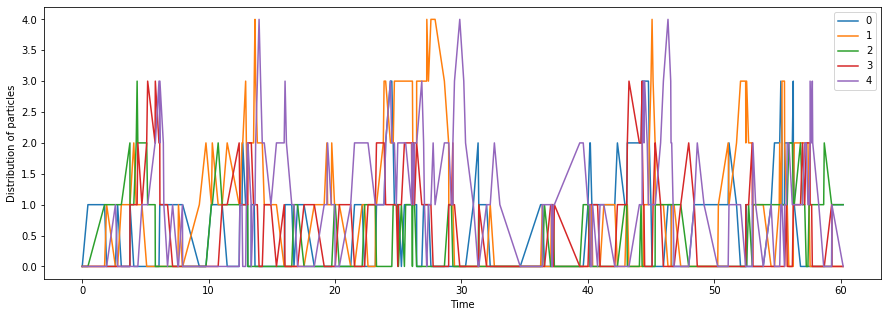

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node].T,label=node)
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()

#### a.2)

We can see that the system is completely stable, to check it the input rate will be boosted to 100 to check if it diverges.

In [27]:
input_rate = 100

In [28]:
num_particles = 0
n_enter = 0
part_dist_time = np.array(np.zeros(len(G.nodes)))
transition_times = [0]
elapsed_time = 0
next_input = 0
node_dist = np.zeros(len(G.nodes))

while elapsed_time < 60:
    #print(num_particles,n_enter,node_dist,elapsed_time)
    if num_particles == 0: # this happens when the graph is empty, it must wait until a particle enters the system
        t_next = -np.log(np.random.rand())/input_rate
        next_input = 0
        elapsed_time += t_next
        node_dist[0] = 1
        num_particles += 1
        n_enter += 1
        part_dist_time = np.column_stack((part_dist_time,node_dist))
        transition_times.append(elapsed_time)
        continue
        
    if next_input <= 0: # this clock determines when a particle enters the system
        next_input += -np.log(np.random.rand())/input_rate
        num_particles += 1
        n_enter += 1
        node_dist[0] += 1
        #part_dist_time = np.column_stack((part_dist_time,node_dist))
        #transition_times.append(elapsed_time)
        
        
    sys_clock = num_particles
    t_next = -np.log(np.random.rand())/sys_clock
    elapsed_time += t_next
    next_input -= t_next
    #print(sys_clock,t_next,next_input,elapsed_time)
    
    #node_dist = part_dist_time[:,-1] # nodes containing how many particles (percentage)
    Node_cum = np.cumsum(node_dist)
    node_chosen = np.argwhere(Node_cum >= np.random.rand()*sys_clock)[0][0]
    # choose the node that will have a departure accordingly to the distribution of the particles
    if node_chosen == 4:
        num_particles -= 1
        node_dist[4] -= 1
        part_dist_time = np.column_stack((part_dist_time,node_dist))
        transition_times.append(elapsed_time)
        continue
        
    
     # choose a random particle in the node with U(0,1)
        # compute the next visited node xi by chosing accordingly to P_bar continuous time distribution
        # at random a neighbor of the current one
    xi = np.argwhere(Q_cum[node_chosen] >= np.random.rand())[0][0]  # choose if the particle should move to a new node pos
                                                    # or remain in the same
        
    node_dist[node_chosen] -= 1
    node_dist[xi] += 1
    part_dist_time = np.column_stack((part_dist_time,node_dist))
    transition_times.append(elapsed_time)


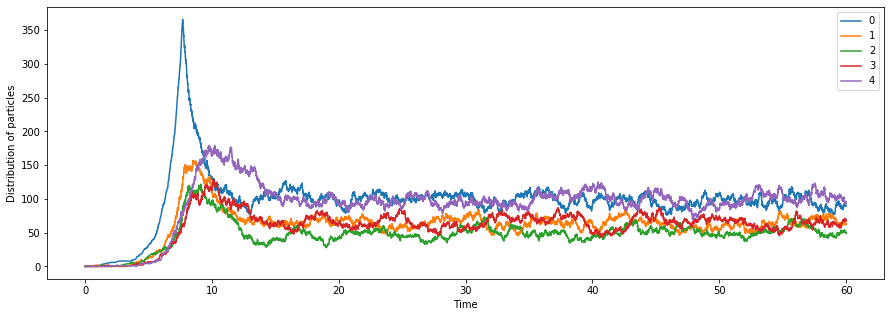

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(transition_times,part_dist_time[node].T,label=node)
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()

Even if it presents a spike that seems to be exponentially divergent in the first 10 time units, it stabilize as much faster to his steady configuration that will elapse from there on.

## b) Fixed rate

For the fixed rate it will be used the OOP paradigm, there is a class NodeClock that must be seen as a sort of exiting gate of each node. The system simulation allows the "green wave" and can allow a movement_time different from 0. This means that if a particle encounter 2 open gates in series at the same time in can pass throught both, this behaviour can be limited by considering a movement time different from None. 
An additional and particular node is the input_gate which determines how many particle per time unit enter into the 'o' node.

### b.1) Simulation

In [30]:
input_rate = 1
system_rate = 1
simulation_time = 60
movement_time = 0 #1e-2

In [31]:
num_particles = 0
n_enter = 0
part_dist_time = np.array(np.zeros(len(G.nodes)))
transition_times = [0]
elapsed_time = 0
next_input = 0


class NodeClock:
    
    def __init__(self, node_id, rate, initial_time=0, particles = 0, input_node = False):
        self.node_id = node_id
        self.rate = rate
        self.total_time = initial_time
        self.ticks = [initial_time]
        self.elapsing_time = [initial_time]
        self.elapsed_ticks = []
        self.external_times = []
        self.emissions = []
        self.inode = input_node
        

        if not input_node:
            self.particles = particles
            self.particles_t = [particles]
            self.external_times_particles = []

        
    def tick(self):
        t = -np.log(np.random.rand())/self.rate
        self.total_time += t
        self.ticks.append(t)
        self.elapsing_time.append(self.total_time)
        return t
    
    def tick_until(self, stop_time):
        while self.total_time < stop_time:
            self.tick()
        return self.ticks
        
    def move(self):
        exit = 0
        if self.particles >= 1:
            self.particles -= 1
            exit = 1
        self.particles_t.append(self.particles)
        return exit
    
    def add_particle(self):
        self.particles += 1

        
    def ext_tick(self, time):
        self.external_times.append(time)
        index = np.argwhere(np.array(self.elapsing_time) <= time)[-1][0]
        out = 0
        if self.elapsing_time[index] not in self.elapsed_ticks:
            if self.inode:
                out = 1 #always entering if is input node
            else:
                out = self.move() #need to check if there are particles available
                self.particles_t.append(self.particles)
                
            self.elapsed_ticks.append(self.elapsing_time[index])
        if not self.inode:
            self.external_times_particles.append(self.particles)
        self.emissions.append(out)
        return out
    
        
t_nexts = dict()
tt_nexts = []
nodes_clocks = dict()
input_node = NodeClock('input',input_rate,input_node=True)
input_times = input_node.tick_until(simulation_time)
tt_nexts.extend(input_times)


for i,node in enumerate(G.nodes):
    nc = NodeClock(node,system_rate)
    nodes_clocks[i] = nc

for i,nc in nodes_clocks.items():
    nc.tick_until(simulation_time)
    cum_ticks = nc.elapsing_time
    #t_nexts[nc.node_id] = t_nexts.get(nc.node_id,list()).append(cum_ticks)
    tt_nexts.extend(cum_ticks)

stt_nexts = sorted(tt_nexts)
ut = np.unique(stt_nexts)

for next_step in stt_nexts:
    insert = input_node.ext_tick(next_step)
    if insert > 0:
        nodes_clocks[0].add_particle()
        next_step += movement_time
    for idx,node in nodes_clocks.items():
        exiting = node.ext_tick(next_step)
        if exiting > 0:
            input_into = np.argwhere(Q_cum[idx] >= np.random.rand())[0][0]
            if input_into != 4:
                nodes_clocks[input_into].add_particle()
            next_step += movement_time
            
resuming = []
for i,node in nodes_clocks.items():
    resuming.append(np.array(node.external_times_particles))
    
resuming = np.array(resuming)

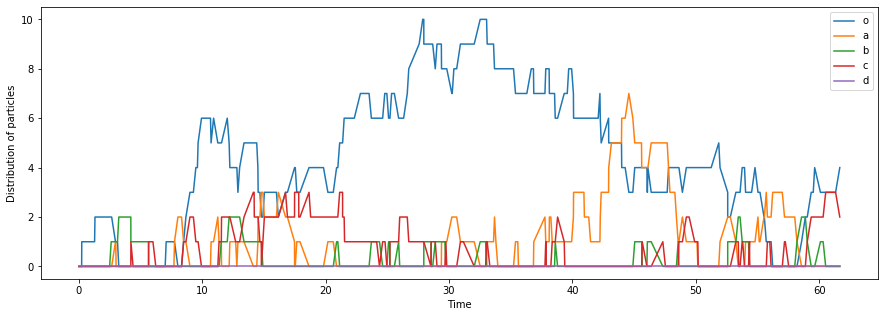

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(stt_nexts,resuming[node],label=node_map_inv[node])
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()

For an input_rate = 1 the system seem to be stable but not as much as the proportional rate one. For a time that grows up to inf even 1.1 could be not stable anymore, but over 60 time units it starts to show a divergent nature with an input_rate of 2

In [33]:
input_rate = 2

In [34]:
num_particles = 0
n_enter = 0
part_dist_time = np.array(np.zeros(len(G.nodes)))
transition_times = [0]
elapsed_time = 0
next_input = 0

t_nexts = dict()
tt_nexts = []
nodes_clocks = dict()
input_node = NodeClock('input',input_rate,input_node=True)
input_times = input_node.tick_until(simulation_time)
tt_nexts.extend(input_times)


for i,node in enumerate(G.nodes):
    nc = NodeClock(node,system_rate)
    nodes_clocks[i] = nc

for i,nc in nodes_clocks.items():
    nc.tick_until(simulation_time)
    cum_ticks = nc.elapsing_time
    #t_nexts[nc.node_id] = t_nexts.get(nc.node_id,list()).append(cum_ticks)
    tt_nexts.extend(cum_ticks)

stt_nexts = sorted(tt_nexts)
ut = np.unique(stt_nexts)

for next_step in stt_nexts:
    insert = input_node.ext_tick(next_step)
    if insert > 0:
        nodes_clocks[0].add_particle()
        next_step += movement_time
    for idx,node in nodes_clocks.items():
        exiting = node.ext_tick(next_step)
        if exiting > 0:
            input_into = np.argwhere(Q_cum[idx] >= np.random.rand())[0][0]
            if input_into != 4:
                nodes_clocks[input_into].add_particle()
            next_step += movement_time
            
resuming = []
for i,node in nodes_clocks.items():
    resuming.append(np.array(node.external_times_particles))
    
resuming = np.array(resuming)

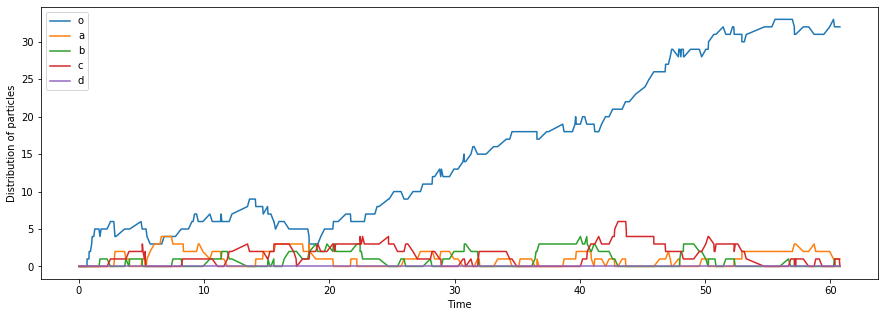

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5)) 
for node in range(len(G)):
    plt.plot(stt_nexts,resuming[node],label=node_map_inv[node])
ax.legend()
plt.xlabel('Time')
plt.ylabel('Distribution of particles')
plt.legend()